## Pergerakan Saham

In [93]:
# !pip install yfinance
# !pip install pandas-datareader
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

In [94]:
yhehehe = yf.Ticker("BBCA.JK")
# get historical market data
overall = yhehehe.history(start='2021-06-30', end='2022-12-30')
hist = yhehehe.history(start="2021-06-30", end="2022-07-01")
actual = yhehehe.history(start='2022-06-30', end='2022-12-30')

hist.to_csv('hist.csv')
actual.to_csv('actual.csv')

hist.Close[-1]

7221.8056640625

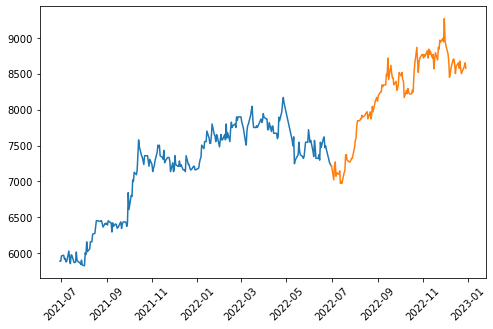

In [95]:
fig,ax = plt.subplots(1, figsize=(8,5))
ax.plot(hist['Close'])
ax.plot(actual['Close'])

plt.xticks(rotation=45)
plt.show()

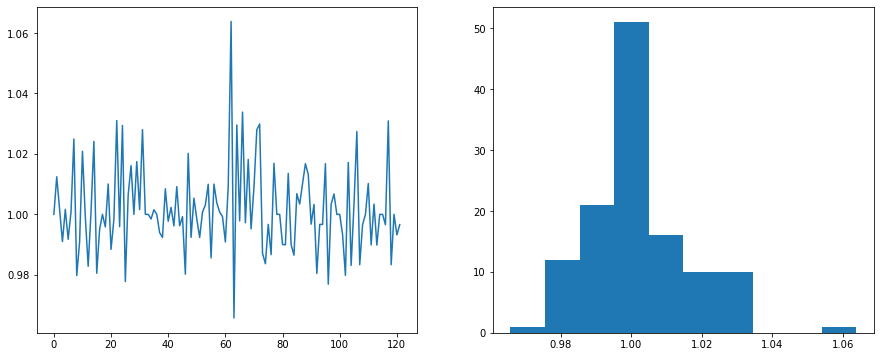

mean, std up 1.0137340814161822 0.012120036706148519
mean, std down 0.9924643842571155 0.00748827093969846
u,d,p= 1.0137340814161822 0.9924643842571155 0.4344262295081967
variansi log saham($sigma^2t$)= 0.08504069508975304


In [96]:
hist['return'] = [hist.Close[i]/hist.Close[i-1] for i in range(1,len(hist))]+[0]
ret = np.array(hist['return'][0:int(len(hist)/2)])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(ret)
ax2.hist(ret, bins=10)
plt.show()

# estimasi parameter metode empiris
print('mean, std up', np.mean(ret[ret>1]), np.std(ret[ret>1]))
print('mean, std down',np.mean(ret[ret<=1]), np.std(ret[ret<=1]))
up= np.mean(ret[ret>1]) # estimasi nilai u empiris
dwn = np.mean(ret[ret<=1])# estimasi nilai d emspiris
p_empi = len(ret[ret>1])/len(ret)
avret = np.mean(ret)
print('u,d,p=', up,dwn,p_empi)
# sigm=(ret-avret)**2

# estimasi MOdel CRR sigma
logS= np.log(np.array([hist.Close[i] for i in range(0,int(len(hist)/2))]))
print('variansi log saham($sigma^2t$)=', np.std(logS))
sig = np.sqrt(np.std(logS)/1)# volatilitas harga saham

In [97]:
import math
# Estimasi nilai sigma dari log(S)
hist['logs'] = [np.log(k) for k in hist['Close']]
logs = np.array(hist['logs'])[0:int(len(hist)/2)+1] 
varLogs=np.std(logs)**2 #\sigma^2t
sigEst= np.sqrt(varLogs/1)
print(len(hist['logs'][int(len(hist)/2)+1:-1]))

120


7221.8056640625
0.08493450048479899


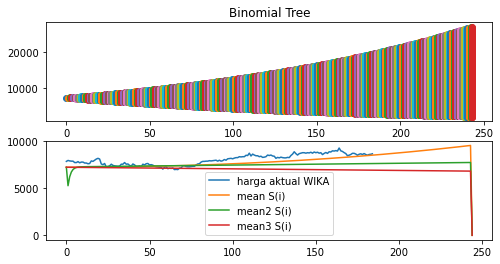

In [98]:
# Membuat pohon Binomial Saham
# So = hist.Close[int(len(hist)/2)]
So = hist.Close[-1]; print(So)
sig = sigEst; print(sig)
r = 0.055 # suku bunagn bank Indonesia
N = 244#251 # harian dalam satu tahun
dt = 1/N
u=np.exp(sig*np.sqrt(dt))
d = np.exp((-sig) * np.sqrt(dt)) # d=1/u
p=(np.exp(-r*dt)-d)/(u-d)

fig,ax = plt.subplots(2,figsize=(8,4))
price = np.zeros((N+1,N+1), float)
mean_si = np.zeros((N+1), float)
mean2_si = np.zeros((N+1), float)
mean3_si = np.zeros((N+1), float)
mean_si[0] = So
mean2_si[0] = So
mean3_si[0] = So
price[0,N] = So
ax[0].scatter(0, price[0,N])
ax[1].plot(range(len(overall.Close[int(len(overall)/2)+1:-1])), overall.Close[int(len(overall)/2)+1:-1], label='harga aktual WIKA')
# ax[1].plot(actual.Close, label='harga aktual WIKA')
for i in range(1,N): # time step 
  for j in reversed(range(i+1)): # jumlah kenaikan
    price[j,i] = So*u**(j)*d**(i-j)
  ax[0].scatter([i for k in range(len(price[0:i+1,i]))], price[0:i+1,i])
  mean_si[i] = np.mean(price[0:i+1,i])
  prob = np.array([math.comb(i+1, i+1-k)*p**(i+1-k)*(1-p)**k for k in range(i+1)])
  # print(prob.shape,price[0:i+1,i].shape )
  mean2_si[i] = np.sum(price[0:i+1,i]*prob) 
  mean3_si[i] = So*u**(i*p)*d**(i-i*p)
    # print(price[j,i])
    # print(j)

ax[0].set_title("Binomial Tree")
ax[1].plot(mean_si, label='mean S(i)')
ax[1].plot(mean2_si, label='mean2 S(i)')
ax[1].plot(mean3_si, label='mean3 S(i)')
plt.legend()

In [99]:
a = np.array([i for i in range(3)])
b = np.array([i for i in reversed(range(3))])
a*b
print(a.shape, b.shape)

(3,) (3,)


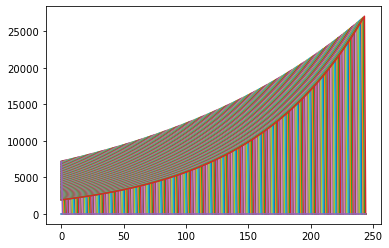

In [100]:
plt.plot(price)
plt.show()

## Monte Carlo Simulation in Financial Stock Model

### Binomial Model for Stock Price
Suppose that discrete time step for a time interval $[0,T]$ is $\{t_0=0, t_1, t_2, \cdots, t_N=T\}$, where $|t_{i+1}-t_{i}|$ are equidistance for all $i$, that is $\Delta t = \frac{T}{N}$. 
Assume that for every time step, stock price can only go up with probability $p$ or down with probability $1-p$. And it has fixed factors for going up or down, respectively are $u$ and $d$.

If at $t_0$, the stock price is $S_0$, then at $t_N$ the stock price will be following the binomial distribution, $x~Binom(x;N,p)$ with $x$ here is the number of $S_0$ going up during $\{t_0=0, t_1, t_2, \cdots, t_N=T\}$. And stock price $S(t_N)$ is written as: 

$S(t_N)=S_N = S_0 u^x d^{N-x}, $ with probability $P(X=x) = \binom{N}{x} p^x (1-p)^{N-x}$ 

#### WHat are the parameters $p,u,$ and $d$?
$p = \frac{e^{-r\Delta t }-d}{u-d} $ 

$u = e^{\sigma \sqrt{\Delta t}}$

$d = e^{-\sigma \sqrt{\Delta t}}$ 

where $r$ is risk free interest rate, and $\sigma$ is the risk of stock return. 

### Stock Price Model at a given time step (Bernouli)
After $\Delta t$, $S(t)$ assume to change following Brown Motion 

In [101]:
# Model CRR
so = hist.Close[-1]
T = 1
N = 100
dt = T / N
r = 0.055 # suku bunga bank Indonesia
sig = sigEst
u = np.exp(sig*np.sqrt(dt))
d = 1/u
p = (np.exp(-r*dt) - d) / (u - d)
M = 5
smt = [[]]

for k in range(M):
  s=so
  sv=[s]
  for i in range(N):
    x = np.random.binomial(i, p)
    s = so * np.power(u, x) * np.power(d, (i-x))
    sv = sv+[s]
  smt = smt+[sv] 

smt=[k for k in smt[1:][:]] 

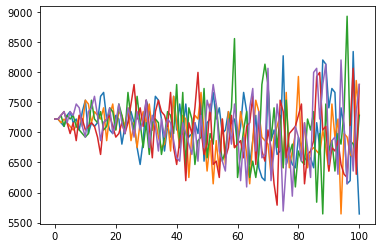

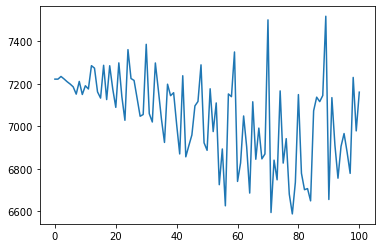

In [102]:
[plt.plot(k) for k in smt]
plt.show()
## Average path of stock prices
smean=np.mean(np.array(smt), axis=0)
plt.plot(smean)

In [103]:
so = hist.Close[-1]
T = 1
N = 100
dt = T / N
r = 0.055 # suku bunga bank Indonesia
M = 5
smt = [[]]

for k in range(M):
  s=so
  sv=[s]
  for i in range(N):
    x = np.random.binomial(i, p_empi)
    s = so * np.power(up, x) * np.power(dwn, (i-x))
    sv = sv+[s]
  smt = smt+[sv] 

smt=[k for k in smt[1:][:]] 

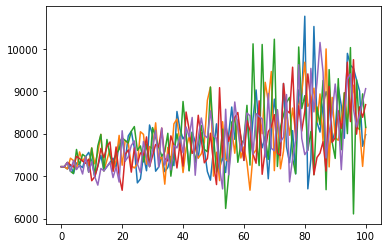

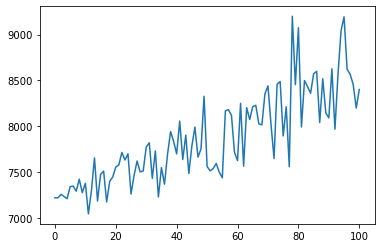

In [104]:
[plt.plot(k) for k in smt]
plt.show()
## Average path of stock prices
smean_emp=np.mean(np.array(smt), axis=0)
plt.plot(smean_emp)